# Generative Adversarial Networks

The MNIST part of this notebook was adapted from [here](https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/VanillaGAN.ipynb).

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.distributions as D

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
from scipy import stats
import datetime
import os, sys

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, imsave

<img src="https://i.imgur.com/25YpgKF.jpg"/>

## Toy problem

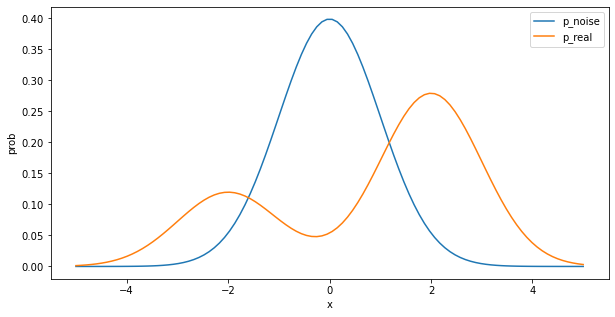

In [3]:
stn = D.Normal(torch.zeros(1,), torch.ones(1,))

mix = D.Categorical(torch.FloatTensor([0.3, 0.7]))
gau = D.Normal(torch.FloatTensor([-2.0, 2.0]), torch.FloatTensor([1.0, 1.0]))
gmm = D.MixtureSameFamily(mix, gau)

def plot_probabilities(stn, gmm, generator=None, discriminator=None, step=None):
    x_grid = torch.linspace(-5, 5, 100)

    p_noise = stn.log_prob(x_grid).exp()
    p_real = gmm.log_prob(x_grid).exp()

    with torch.no_grad():
        if discriminator is not None:
            p_classifer = discriminator(x_grid[:, None])[:, 0]
        
        if generator is not None:
            x_fake = generator(torch.randn_like(x_grid)[:, None])[:, 0]
            p_fake = torch.from_numpy(stats.gaussian_kde(x_fake.cpu().numpy())(x_grid))

    plt.figure(figsize=(10, 5))

    if step is not None:
        plt.title(f'step {step}')
    
    plt.xlabel('x')
    plt.ylabel('prob')
    plt.plot(x_grid, p_noise)
    plt.plot(x_grid, p_real)

    legend = ['p_noise', 'p_real']

    if discriminator is not None:
        plt.plot(x_grid, p_classifer)
        legend.append('p_classifier')
    
    if generator is not None:
        plt.plot(x_grid, p_fake)
        legend.append('p_fake')
    
    plt.legend(legend)
    plt.show()

plot_probabilities(stn, gmm)

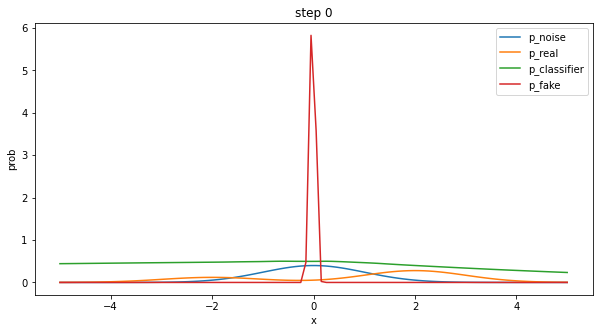

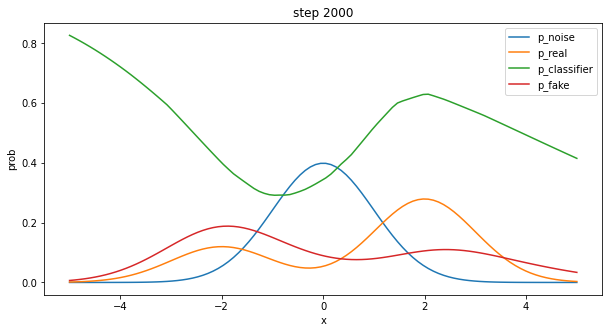

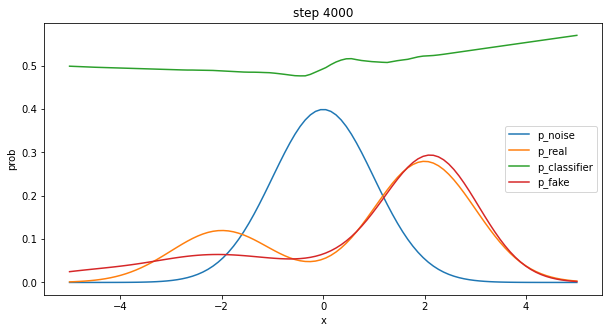

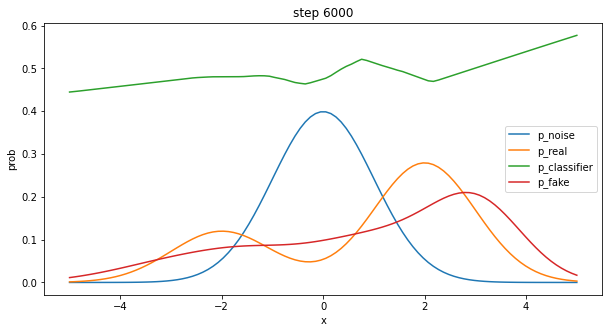

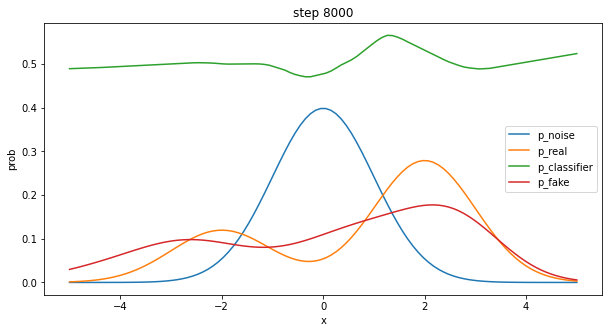

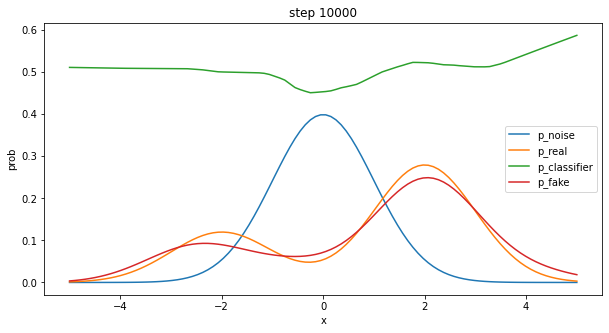

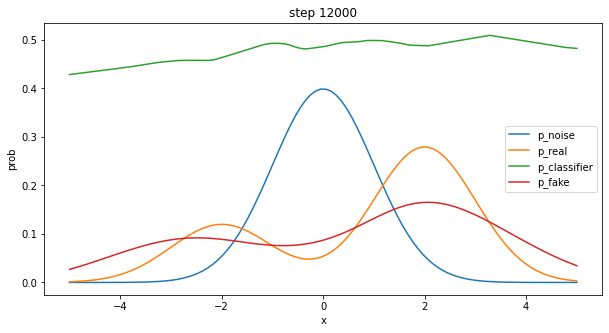

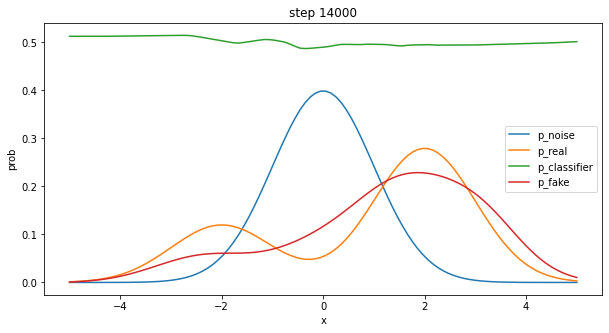

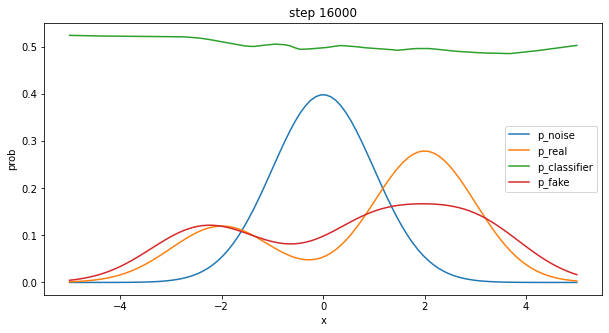

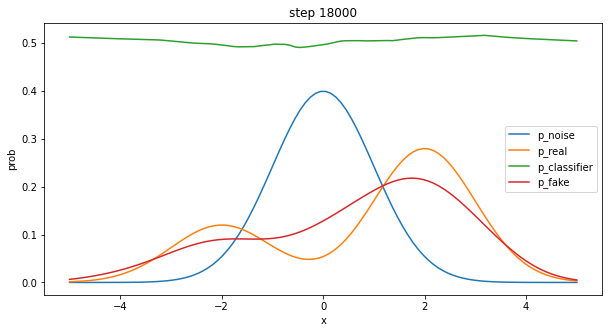

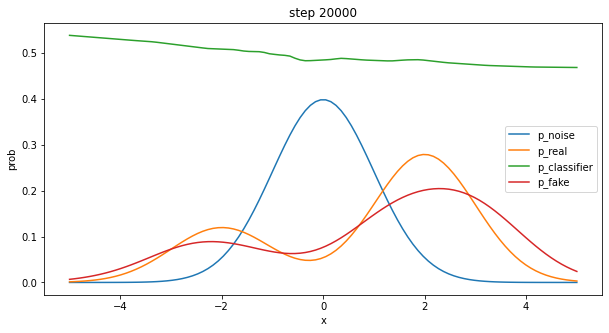

In [4]:
# Train a simple GAN
generator = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
) # TODO: an MLP, latent dim of 32

discriminator = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)
# TODO: same as generator

opt_gen = optim.Adam(generator.parameters(), lr=1e-4) # TODO: use Adam with lr = 1e-4
opt_dis = optim.Adam(discriminator.parameters(), lr=1e-4) # TODO: use Adam with same lr

batch_size = 64
real_label = torch.ones(64, 1)
fake_label = torch.zeros(64, 1)

num_dis_steps_per_gen_step = 1
num_steps = 20000
fig = None

plot_probabilities(stn, gmm, generator, discriminator, 0)

for i in range(1, num_steps + 1):
    for j in range(num_dis_steps_per_gen_step):
        x_real = gmm.sample((batch_size, 1))
        x_fake = generator(torch.randn(batch_size, 1)).detach()

        real_pred = discriminator(x_real)
        fake_pred = discriminator(x_fake)

        loss_dis = F.binary_cross_entropy(real_pred, real_label) + F.binary_cross_entropy(fake_pred, fake_label) # TODO: implement a non-saturating loss for dis
        
        opt_dis.zero_grad()
        loss_dis.backward()
        opt_dis.step()

    x_fake = generator(torch.randn(batch_size, 1))
    fake_pred = discriminator(x_fake)
    
    loss_gen = F.binary_cross_entropy(fake_pred, real_label) # TODO: implement a non-saturating loss for gen
    
    opt_gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    if not i % (num_steps // 10):
        plot_probabilities(stn, gmm, generator, discriminator, i)

## MNIST

In [5]:
MODEL_NAME = 'vanilla'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [8]:
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])])

mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

9913344it [00:00, 30673336.27it/s]                             


Extracting ../data/MNIST\raw\train-images-idx3-ubyte.gz to ../data/MNIST\raw



29696it [00:00, 29747803.10it/s]         


Extracting ../data/MNIST\raw\train-labels-idx1-ubyte.gz to ../data/MNIST\raw



1649664it [00:00, 9333447.07it/s]                            


Extracting ../data/MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/MNIST\raw



5120it [00:00, ?it/s]                   

Extracting ../data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/MNIST\raw



In [9]:
class Discriminator(nn.Module):
    """
        TODO: implement a simple discriminator as a two-layer an MLP with 512 and 256 hidden dims
    """
    def __init__(self, input_size=784):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [10]:
class Generator(nn.Module):
    """
        TODO: implement a simple generator as a four-layer MLP 
        with 128, 256, 512, 1024 hidden dims and
        with BatchNorms
    """
    def __init__(self, input_size=100, output_size=784):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, output_size),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.net(x)

In [11]:
n_noise = 100

discriminator = Discriminator().to(DEVICE)
generator = Generator(n_noise).to(DEVICE)

In [12]:
criterion = nn.MSELoss()
D_opt = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.0, 0.999))
G_opt = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.0, 0.999))

In [13]:
max_epoch = 10 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [14]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [15]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [16]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        images = images.cuda().view(batch_size, -1)

        # TODO: gradient step w.r.t. the discriminator
        real_preds = discriminator(images)

        fake_images = generator(torch.randn(batch_size, n_noise).cuda()).detach()
        fake_preds = discriminator(fake_images)

        D_loss = F.mse_loss(real_preds, D_labels) + F.mse_loss(fake_preds, D_fakes)

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # TODO: gradient step w.r.t. the generator
            fake_images = generator(torch.randn(batch_size, n_noise).cuda())
            fake_preds = discriminator(fake_images)

            G_loss = F.mse_loss(fake_preds, D_labels)

            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            generator.eval()
            img = get_sample_image(generator, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            generator.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 0.4789494276046753, G Loss: 0.26194682717323303
Epoch: 0/10, Step: 500, D Loss: 0.4523125886917114, G Loss: 0.21096724271774292
Epoch: 1/10, Step: 1000, D Loss: 0.4517689645290375, G Loss: 0.23057475686073303
Epoch: 1/10, Step: 1500, D Loss: 0.4728602170944214, G Loss: 0.279603511095047
Epoch: 2/10, Step: 2000, D Loss: 0.48606163263320923, G Loss: 0.3256354331970215
Epoch: 2/10, Step: 2500, D Loss: 0.44657063484191895, G Loss: 0.325067937374115
Epoch: 3/10, Step: 3000, D Loss: 0.47516557574272156, G Loss: 0.3023598790168762
Epoch: 3/10, Step: 3500, D Loss: 0.46861281991004944, G Loss: 0.32212674617767334
Epoch: 4/10, Step: 4000, D Loss: 0.48962897062301636, G Loss: 0.39035019278526306
Epoch: 4/10, Step: 4500, D Loss: 0.47071704268455505, G Loss: 0.3021809458732605
Epoch: 5/10, Step: 5000, D Loss: 0.4771069288253784, G Loss: 0.3270553946495056
Epoch: 5/10, Step: 5500, D Loss: 0.48616084456443787, G Loss: 0.268406480550766
Epoch: 6/10, Step: 6000, D Loss: 0.

## Visualize Sample

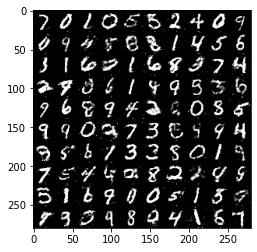

In [17]:
# generation to image
generator.eval()
imshow(get_sample_image(generator, n_noise), cmap='gray')